# MS Big Data - Telecom Paristech - Big data pour la géolocalisation d'objets connectés

## Importation des modules et des données

In [42]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
import folium
from IPython.display import IFrame

In [2]:
# load train and test data
path = "C:/Users/JN/Desktop/Telecom PT/IoT/TP/TPgeoloc/TP_geoloc/"
df_mess_train = pd.read_csv(path+'mess_train_list.csv')
df_mess_test = pd.read_csv(path+'mess_test_list.csv')
pos_train = pd.read_csv(path+'pos_train_list.csv')

In [3]:
# determine all Base stations that received at least 1 message
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) 
len(listOfBs)

259

## Exploration des données

In [29]:
# DataFrame des coordonnées tous les bs qui ont reçu au moins un message :
bsid_train = df_mess_train[['bsid', 'bs_lat', 'bs_lng']]
bsid_test = df_mess_test[['bsid', 'bs_lat', 'bs_lng']]
bsid_merged = pd.concat([bsid_train, bsid_test])
listOfBsDF = bsid_merged.drop_duplicates()
listOfBsDF = listOfBsDF.reset_index().drop('index', axis=1)

pos_train_U = pos_train.drop_duplicates()
pos_train_U = pos_train_U.reset_index().drop('index', axis=1)

Sur la base des coordonnées fournies, nous positionnons sur une carte les bornes réceptrices des messages de train et de test ('bsid'), diffusés par l'ensemble des devices ('did') :

In [44]:
#### bsid #####

map_osm = folium.Map(location=[55, -90], zoom_start=3, tiles='Stamen Terrain') #OpenStreetMap #Stamen Terrain

for i in range(len(listOfBsDF)-1):
    folium.Marker([listOfBsDF['bs_lat'][i], listOfBsDF['bs_lng'][i]], 
                  popup=listOfBsDF.iloc[i]['bsid'].astype(int).astype(str)).add_to(map_osm)
        
map_osm.save('bsid_usa_general.html')

IFrame(src='bsid_usa_general.html', width=900, height=500)

#### Nous observons une répartition relativement homogène de ces bornes, suivant un axe traversant les Etats-Unis, du sud du Colorado jusqu'au nord de l'état du Wyoming.
Nous constatons que le périmètre dans lequel se situe ces bornes est essentiellement constitué d'une zone urbaine et d'une zone dont le relief est plus accidenté, le maillage de bornes dans le milieu urbain se faisant plus dense que celui de la zone accidentée, dans laquelle il est plus éparse.

In [43]:
#### bsid train + test #####

map_osm = folium.Map(location=[40, -105], zoom_start=6, tiles='Stamen Terrain') #OpenStreetMap

for i in range(len(listOfBsDF)-1):
    folium.Marker([listOfBsDF['bs_lat'][i], listOfBsDF['bs_lng'][i]], 
                  popup=listOfBsDF.iloc[i]['bsid'].astype(int).astype(str)).add_to(map_osm)

        
map_osm.save('bsid_states_zoom1.html')

IFrame(src='bsid_states_zoom1.html', width=900, height=500)

#### Détection d'outliers (1/2) :
Nous remarquons la présence d'une première borne isolée, très éloignée des autres et de tout autre device (plusieurs milliers de kilomètres), se situant dans le passage du Nord-Ouest dans l'archipel arctique canadien (dans le territoire du Nunavut) :

In [45]:
#### bsid train + test / Outlier 1/3 #####

map_osm = folium.Map(location=[55, -90], zoom_start=3, tiles='Stamen Terrain') #OpenStreetMap #Stamen Terrain

for i in range(len(listOfBsDF)-1):
    folium.Marker([listOfBsDF['bs_lat'][i], listOfBsDF['bs_lng'][i]], 
                  popup=listOfBsDF.iloc[i]['bsid'].astype(int).astype(str)).add_to(map_osm)

folium.Circle(
    radius=200000,
    location=[64.3, -68.5],
    color='crimson',
    fill=True)\
    .add_to(map_osm)
        
map_osm.save('bsid_usa.html')

IFrame(src='bsid_usa.html', width=900, height=500)

#### Détection d'outliers (2/2) :
Nous remarquons ensuite, une balise isolée dans le nord du Montana, à près de 1000 km des autres bornes ou device :

In [61]:
#### bsid train + test / Outlier 2/3 #####

map_osm = folium.Map(location=[43, -105], zoom_start=5, tiles='Stamen Terrain') #OpenStreetMap

for i in range(len(listOfBsDF)-1):
    folium.Marker([listOfBsDF['bs_lat'][i], listOfBsDF['bs_lng'][i]], 
                  popup=listOfBsDF.iloc[i]['bsid'].astype(int).astype(str)).add_to(map_osm)

folium.Circle(
    radius=80000,
    location=[48.072889, -110.957181],
    color='crimson',
    fill=True)\
    .add_to(map_osm)

folium.Circle(
    radius=80000,   
    location=[43.429223, -103.479163],
    color='crimson',
    fill=True)\
    .add_to(map_osm)
        
map_osm.save('bsid_states1.html')

IFrame(src='bsid_states1.html', width=900, height=500)

Enfin, nous observons 10 balises situées dans le Dakota du Sud, à plus de 300km des autres balises et devices.

La superposition de la position des balises captant les messages des devices dans le jeu de données d'entrainement, avec la position des devices eux-mêmes, nous montre qu'aucun device ne se situe à proximité de ces outliers.
Ces derniers ne nous aideraient alors pas dans notre démarche de prédiction de leur position.


Nous pouvons donc légitimement nous interroger sur la pertinence de la suppression de ces outliers pour la construction de notre modèle.


Il serait néanmoins utile de déterminer si les devices dont les messages sont captés par ces outliers présentent des caractéristiques communes afin de ne pas perdre d'information à l'issue de cette suppression.

In [49]:
#### bsid_train + pos_train + bsid_test #####

print("\n Superposition des balises (en noir) et des devices (en rouge) du jeu d'entrainement : ")

map_osm = folium.Map(location=[listOfBsDF['bs_lat'][87], listOfBsDF['bs_lng'][87]], zoom_start=6, tiles='OpenStreetMap') #OpenStreetMap #Stamen Terrain

for i in range(len(pos_train_U)-1):
    folium.Circle(
        radius=10,
        location=[pos_train_U['lat'][i], pos_train_U['lng'][i]],
        color='crimson',
        fill=True)\
    .add_to(map_osm)
    
for j in range(len(listOfBsDF)-1):
    folium.Circle(
        radius=30,
        location=[listOfBsDF['bs_lat'][j], listOfBsDF['bs_lng'][j]],
        popup=listOfBsDF.iloc[j]['bsid'].astype(int).astype(str),
        color='black',
        fill=True)\
    .add_to(map_osm)

map_osm.save('bsid_superpose.html')

IFrame(src='bsid_superpose.html', width=700, height=600)


 Superposition des balises (en noir) et des devices (en rouge) du jeu d'entrainement : 


In [50]:
#bsid outliers :
print('\n Tableaux des outliers (balises):')
pd.concat([listOfBsDF[listOfBsDF['bsid']==9941],
           listOfBsDF[listOfBsDF['bsid']==9936],
           listOfBsDF[listOfBsDF['bsid']==2808],
          listOfBsDF[listOfBsDF['bsid']==3848],
           listOfBsDF[listOfBsDF['bsid']==2800],
           listOfBsDF[listOfBsDF['bsid']==3501],
           listOfBsDF[listOfBsDF['bsid']==4013],
          listOfBsDF[listOfBsDF['bsid']==2803],
           listOfBsDF[listOfBsDF['bsid']==3630],
           listOfBsDF[listOfBsDF['bsid']==3933],
           listOfBsDF[listOfBsDF['bsid']==1443],
          listOfBsDF[listOfBsDF['bsid']==7508]])

# 9941, 9936, 2808, 3848, 2800, 3501, 4013, 2803, 3630, 3933, 1443, 7508


 Tableaux des outliers (balises):


,bsid,bs_lat,bs_lng
256,9941,64.300000,-68.500000
255,9936,48.072889,-110.957181
234,2808,43.599230,-103.712388
232,3848,43.614138,-103.723449
236,2800,43.631515,-103.765896
238,3501,43.639226,-103.761023
239,4013,43.651403,-103.745268
233,2803,43.657077,-103.756890
235,3630,43.657480,-103.790401
237,3933,43.671528,-103.815822


#### Recherche de corrélations entre les variables

C:\Users\JN\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


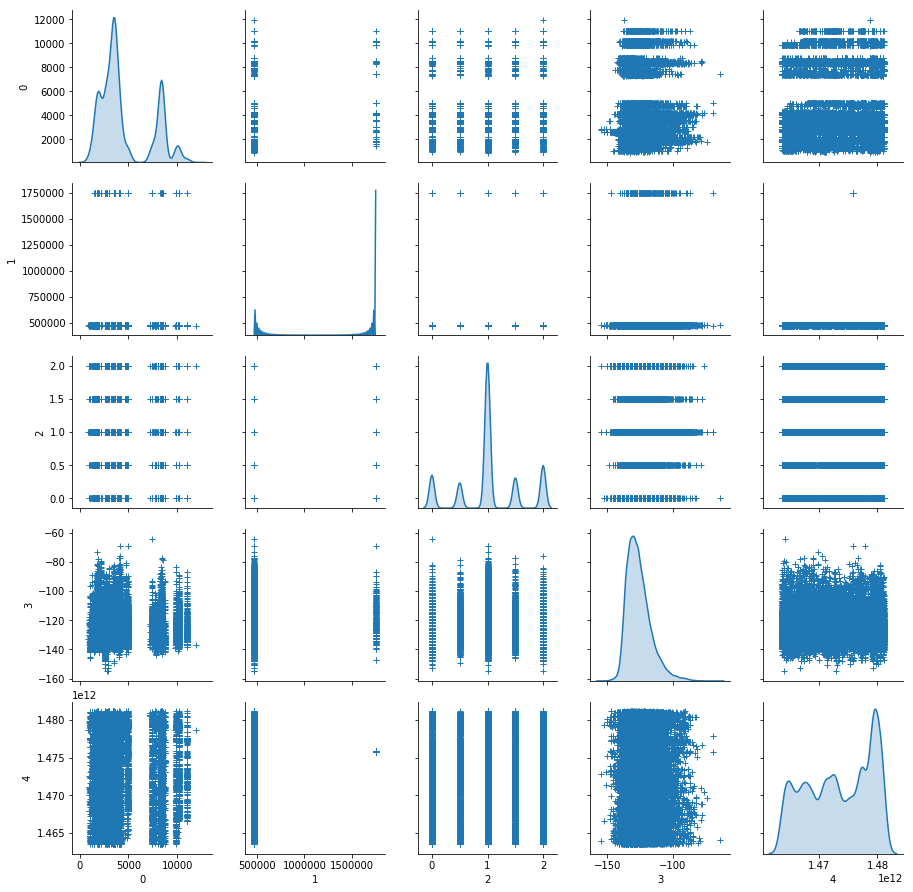

In [51]:
v, w, x, y, z = \
df_mess_train['bsid'],\
df_mess_train['did'],\
df_mess_train['nseq'],\
df_mess_train['rssi'],\
df_mess_train['time_ux']

df2 = np.transpose(np.vstack((v,w,x,y,z)))
df2 = pd.DataFrame(df2)

sns.pairplot(df2,  diag_kind="kde", markers = '+', plot_kws=dict(s=30, edgecolor="b", linewidth=1), \
             diag_kws=dict(shade=True))
plt.show()

Nous n'obervons pas de relation particulière entre les paires de variables explicatives.

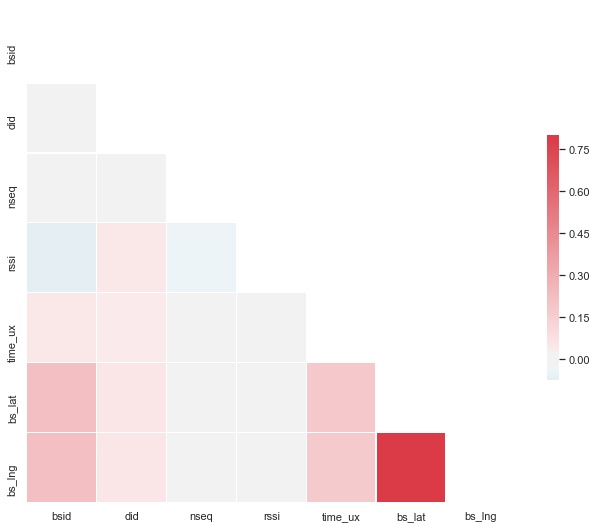

In [52]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(df_mess_train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_mess_train.corr(), mask=mask, cmap=cmap, vmax=0.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

La heatmap confirme notre remarque précédente : il semble ne pas y avoir de corrélation entre variables explicatives (hormis bs_lng et bs_lat).

#### Différences entre le train set et le test set

On remarque que 38 bsids qui sont présents dans le test set sont absents du train set

In [116]:
new_bsids = [k for k in df_mess_test['bsid'].values if k not in df_mess_train['bsid'].values]
old_bsids = df_mess_train['bsid'].unique()
len(new_bsids)

38

On constate que 33 messages ont été captés par ces bsids:

In [109]:
msg_new_bsids_idx = df_mess_test[df_mess_test['bsid'].isin(new_bsids)].messid.unique()
len(msg_new_bsids_idx)

33

Ces messages apparaissent 76 fois dans le test set:

In [119]:
msg_new_bsids = df_mess_test[df_mess_test['bsid'].isin(new_bsids)].messid.unique()
msg_test_bsid_inconnu = df_mess_test[df_mess_test['messid'].isin(msg_new_bsids)]
msg_test_bsid_inconnu

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
3775,575ba63e864fce5689565f66,3034,472960.0,2.0,-131.000000,1.465624e+12,41.827396,-106.833117
3776,575ba63e864fce5689565f66,3828,472960.0,1.0,-132.500000,1.465624e+12,41.843843,-106.810148
8413,578a1045cf554f22c1e41064,3034,472151.0,1.0,-126.000000,1.468666e+12,41.827396,-106.833117
8414,578a1045cf554f22c1e41064,3828,472151.0,2.0,-135.000000,1.468666e+12,41.843843,-106.810148
12501,57a9e6e612f14345913afbc5,9783,473281.0,1.0,-140.000000,1.470752e+12,36.785088,-102.737426
12502,57a9e99c12f14345913ce528,9783,473281.0,1.0,-139.333333,1.470753e+12,36.785088,-102.737426
12505,57a9ec69cf554f465adc2dd8,9783,473281.0,0.5,-135.000000,1.470754e+12,36.785088,-102.737426
12507,57a9edcdcf554f465add3c93,9783,473281.0,2.0,-139.000000,1.470754e+12,36.785088,-102.737426
12508,57a9ef27cf554f465ade591a,9783,473281.0,1.0,-140.666667,1.470755e+12,36.785088,-102.737426
12509,57a9f084e541cd77a020313d,9783,473281.0,2.0,-140.000000,1.470755e+12,36.785088,-102.737426


Parmi tous ces messages, combien combien ont été captés par des bsids présents dans le train set?

In [120]:
msg_test_bsid_inconnu[msg_test_bsid_inconnu['bsid'].isin(old_bsids)].messid.unique()

array(['57feb04be541cd17032f6f03', '581cd7bd12f1434b9cec032c'],
      dtype=object)

On voit ainsi que seuls deux messages parmi les 33 ont été reçus par des bsids. Comme ces nouveaux bsids ne feront pas partie du train set, il sera difficile pour un modèle de déduire la position d'un device à partir des seules coordonnées de ces nouveaux bsids. Aussi, nous considérerons que les devices qui ont émis ces messages se trouvaient au barycentre des bsids qui les ont reçus. Les positions prédites apparaissent ci-dessous:

In [126]:
pred_new_bsids = msg_test_bsid_inconnu.groupby('messid').mean()
pred_new_bsids[['bs_lat','bs_lng']].head()

,bs_lat,bs_lng
messid,,
575ba63e864fce5689565f66,41.835620,-106.821632
578a1045cf554f22c1e41064,41.835620,-106.821632
57a9e6e612f14345913afbc5,36.785088,-102.737426
57a9e99c12f14345913ce528,36.785088,-102.737426
57a9ec69cf554f465adc2dd8,36.785088,-102.737426


## Preprocessing

### Fonctions initiales

Ci-dessous les fonctions de preprocessing et d'évaluation utilisées dans ce notebook:

In [5]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [6]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [7]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [8]:
# Feature Matrix construction 

def feat_mat_const(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = 1
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

### Fonctions additionnelles

Pour approfondir le travail sur les features, nous avons ajouté les fonctions ci-dessous:

Nous avons cherché à déterminer si les résultats d'un modèle se trouveraient améliorés si les coordonnées des devices et des stations étaient exprimées dans un référentiel différent, d'où les fonctions ci-dessous: 

In [9]:
from pyproj import Proj, transform

def convertRowGeoData (inProj, outProj, row, col1Name, col2Name) :
    x2,y2 = transform(inProj,outProj,row.iloc[0],row.iloc[1])
    return pd.Series({col1Name:x2,col2Name:y2})

def convertGeoData(epsgin, epsgout, df) :
    inProj = Proj(init='epsg:'+str(epsgin))
    outProj = Proj(init='epsg:'+str(epsgout))
    col1Name = df.columns[0]
    col2Name = df.columns[1]
    dfcopy = df.copy()
    ret = pd.DataFrame()
    return dfcopy.apply(lambda x : convertRowGeoData(inProj, outProj, x, col1Name, col2Name),axis=1)

Par ailleurs, les données sources contiennent de nombreuses informations qui peuvent compléter les données issues de la fonction feat_mat_const. Nous avons donc défini la fonction ci-dessous qui convertit ces features addtionnelles en un dataframe indexé par messid:

In [10]:
# Feature Matrix construction - on ajoute des colonnes correspondant à la force des signaux perçus par chaque bs
def feat_mat_const_additional_features(df_mess_train, listOfBs, col_titles):
    """
    inputs: 
        df_mess_train, listOfBs: idem fonction feat_mat_const
        col_titles: list de strings: doit contenir des noms de features relatives aux base stations
    output:
        dataframe indexé sur les identifiants des messages, contenant, pour chaque base station qui
        reçoit un message donné, les features spécifiées dans l'argument col_title
    """
    
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    headers = []
    df_feats = []
    
    for element in col_titles:
        newfeat_by_bs_headers = np.array([element+"_bs_"+str(bs) for bs in listOfBs])
        headers.append(newfeat_by_bs_headers)
        df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # new feature matrix
        
        idx = 0
        id_list = [0] * nb_mess
        print("processing feature %s out of %s" %(str(len(df_feats)+1),str(len(col_titles))))


        for key, elmt in df_mess_bs_group:
            group = df_mess_bs_group.get_group(key)

            for i in group['bsid']:
                df_feat.loc[idx,i] = group[group['bsid']==i][element].iloc[0]

            id_list[idx] = key
            idx = idx + 1  

        df_feat.rename(columns = dict(zip(listOfBs, newfeat_by_bs_headers)), inplace=True)
    
        df_feats.append(df_feat)
        
    result = pd.concat(df_feats, axis=1)
    return result

## Entraînement et prédiction au moyen d'une forêt aléatoire

### Mise en forme des données

In [66]:
#les données sont traitées au moyen des fonctions de preprocessing évoquées plus haut
#la fonction feat_mat_const_additional features peut être un peu longue à exécuter
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_train['bsid'])) 
df_feat, id_list_train = feat_mat_const(df_mess_train, listOfBs)
df_feat_additional = feat_mat_const_additional_features(df_mess_train, listOfBs,
                                                        ['did','rssi','time_ux','bs_lat','bs_lng'])
df_feat2 = pd.concat([df_feat, df_feat_additional], axis=1)
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)

processing feature 1 out of 5
processing feature 2 out of 5
processing feature 3 out of 5
processing feature 4 out of 5
processing feature 5 out of 5


### Définition d'un ensemble d'entraînement et d'un ensemble de validation pour tester le modèle avant de l'appliquer aux données test

In [13]:
X = df_feat2
Y_lat = ground_truth_lat
Y_long = ground_truth_lng

Xtrain, Xtest, Ytrain_lat, Ytest_lat = train_test_split(X, Y_lat, test_size=0.2)
Ytrain_long = Y_long[Xtrain.index.values]
Ytest_long = Y_long[Xtest.index.values]

### Entraînement d'un premier modèle et identification des features les plus importantes

Une fois les données traitées, nous les avons soumise à une forêt aléatoire, dont les paramètres (nombre d'estimateurs fixé à 200, profondeur maximale non plafonnée, nombre de features maximal pour l'entraînement de chaque arbre) ont été fixés à l'issue d'une série de tests effectués pour maximiser le score du modèle:

2731.6419201867657

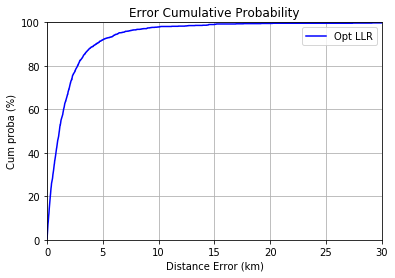

In [14]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    X_train = np.array(df_feat);
    rf = RandomForestRegressor(n_estimators=200, max_features='log2', max_depth=None, n_jobs=-1, verbose=0)

    rf.fit(X_train, ground_truth_lat);
    y_pred_lat = rf.predict(df_test) 

    rf.fit(X_train, ground_truth_lng);
    y_pred_lng = rf.predict(df_test) 
    
    return y_pred_lat, y_pred_lng



#prédiction et affichage des résultats
y_pred_lat, y_pred_lng = regressor_and_predict(Xtrain, Ytrain_lat, Ytrain_long, Xtest)
err_vec = Eval_geoloc(Ytest_lat , Ytest_long, y_pred_lat, y_pred_lng)

#Plot error distribution 
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

# Error criterion
np.percentile(err_vec, 80)

On constate que le score est significativement amélioré par rapport à la régression linéaire proposée dans le template de projet (environ 2 700m contre environ 7 500m). Cependant, lors du preprocessing, nous avons ajouté un grand nombre de features (5 features supplémentaires par bsid, soit 259 * 5 = 1295 colonnes supplémentaires). Il n'est pas certain que toutes ces features contribuent à améliorer la précision du modèle. Nous allons donc étudier l'importance de ces features.

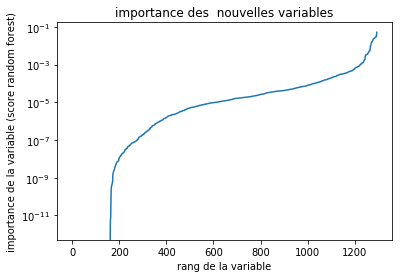

In [16]:
rf = RandomForestRegressor(n_estimators=200, max_features='log2', max_depth=None, n_jobs=-1, verbose=0)
rf.fit(Xtrain, Ytrain_lat);
importance_df=pd.DataFrame(rf.feature_importances_, index=Xtrain.columns.values)

#on ne s'intéresse en particulier aux features ajoutées:
old_features = df_feat.columns
new_features = [col_title for col_title in importance_df.index.values if col_title not in old_features]
importance_new_features = importance_df.loc[new_features]
importance_new_features.shape

#affichage de l'importance des features, dans l'ordre croissant
plt.yscale('log')
plt.plot(range(importance_new_features.shape[0]), sorted(importance_new_features[0]))
plt.xlabel('rang de la variable')
plt.ylabel('importance de la variable (score random forest)')
plt.title('importance des  nouvelles variables')
plt.show()

On constate de très fortes disparités (plusieurs ordres de grandeur) entre les différentes features additionnelles. Il semble donc justifié d'en retirer certaines des données d'entrée du modèle. Pour ce faire, on va définir un seuil d'importance en-deçà duquel les features seront retirées, à l'aide de la fonction clean_useless_features définie ci-dessous:

In [27]:
#on retire de Xtrain et de Xtest toutes les variables dont l'importance est inférieure à un certain seuil:
threshold = 10e-5

def clean_useless_features(threshold_list):
    scores = []
    for threshold in threshold_list:
        features_to_drop = importance_new_features[importance_new_features[0]<threshold].index.values
        X_red = df_feat2.drop(features_to_drop, axis=1)
        Y_lat = ground_truth_lat
        Y_long = ground_truth_lng
   
        Xtrain_red = Xtrain.drop(features_to_drop, axis=1)
        Xtest_red = Xtest.drop(features_to_drop, axis=1)

        y_pred_lat, y_pred_lng = regressor_and_predict(Xtrain_red, Ytrain_lat, Ytrain_long, Xtest_red)
        err_vec = Eval_geoloc(Ytest_lat , Ytest_long, y_pred_lat, y_pred_lng) 
        
        scores.append(np.percentile(err_vec, 80))
                              
    return scores

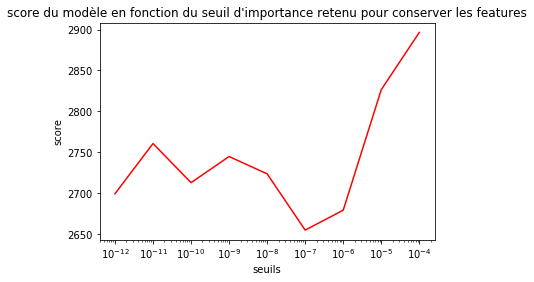

In [32]:
threshold_list = [10**k for k in range(-12,-3)]
scores = clean_useless_features(threshold_list)
plt.plot(threshold_list, scores, color='r')
plt.xlabel('seuils')
plt.ylabel('score')
plt.xscale('log')
plt.title("score du modèle en fonction du seuil d'importance retenu pour conserver les features")
plt.show()

Dans la suite, on retire donc toutes les features d'une importance inférieure au seuil ainsi trouvé.

In [141]:
threshold = threshold_list[np.argmin(scores)]
features_to_drop = importance_new_features[importance_new_features[0]<threshold].index.values

### Entraînement du modèle final, et exportation des prédictions sur le test set

Retrait des messages captés par les nouveaux bsids du test set:

In [194]:
msg_to_keep = [idx for idx in df_mess_test.index.values if not idx in msg_test_bsid_inconnu.index.values]
msg_to_remove = [idx for idx in df_mess_test.index.values if idx in msg_test_bsid_inconnu.index.values]
df_mess_test2 = df_mess_test.loc[msg_to_keep]

Preprocessing du test set:

In [135]:
listOfBs_test = np.union1d(np.unique(df_mess_test2['bsid']), np.unique(df_mess_test2['bsid'])) 
df_feat_test, id_list_test = feat_mat_const(df_mess_test2, listOfBs_test)
df_feat_additional_test = feat_mat_const_additional_features(df_mess_test2, listOfBs_test,
                                                        ['did','rssi','time_ux','bs_lat','bs_lng'])
df_feat_test2 = pd.concat([df_feat_test, df_feat_additional_test], axis=1)

processing feature 1 out of 5
processing feature 2 out of 5
processing feature 3 out of 5
processing feature 4 out of 5
processing feature 5 out of 5


Suppression des colonnes superflues du test set:

In [144]:
features_to_drop_test = [f for f in features_to_drop if f in df_feat_test2.columns]
Xtest = df_feat_test2.drop(features_to_drop_test, axis=1)
Xtest.shape

(5261, 933)

Suppression des colonnes superflues du train set

In [155]:
features_to_drop1 = [f for f in features_to_drop if f in df_feat2.columns]
Xtrain = df_feat2.drop(features_to_drop1, axis=1)

features_to_drop2 = [f for f in Xtrain.columns if f not in Xtest.columns]
Xtrain2 = Xtrain.drop(features_to_drop2, axis=1)

Xtrain2.shape


(6068, 933)

Entraînement du modèle

In [157]:
rf_lat = RandomForestRegressor(n_estimators=200, max_features='log2', max_depth=None, n_jobs=-1, verbose=0)
rf_long = RandomForestRegressor(n_estimators=200, max_features='log2', max_depth=None, n_jobs=-1, verbose=0)

rf_lat.fit(Xtrain2, Y_lat)
rf_long.fit(Xtrain2, Y_long)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Prédiction

In [159]:
y_pred_lat = rf_lat.predict(Xtest)
y_pred_lng = rf_long.predict(Xtest)

In [165]:
y_pred_lat

array([39.8350312 , 39.77813695, 39.67685558, ..., 39.67149529,
       39.66929368, 39.65543669])

Stockage des résultats dans un dataframe puis réassemblage avec les messages retirés précédemment:

In [193]:
results = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, index=Xtest.index)
results.rename(columns={0:'lat',1:'lng'}, inplace=True)
results['messid']=id_list_test
results.head()

,lat,lng,messid
0,39.835031,-105.149548,573be2503e952e191262c351
1,39.778137,-105.070785,573c05f83e952e1912758013
2,39.676856,-105.003559,573c0796f0fe6e735a66deb3
3,39.805470,-105.098648,573c08d2864fce1a9a0563bc
4,39.676766,-105.003065,573c08ff864fce1a9a0579b0


In [208]:
results_new_bsids = pred_new_bsids[['bs_lat','bs_lng']]
results_new_bsids.rename(columns={'bs_lat':'lat','bs_lng':'lng'}, inplace=True)
results_new_bsids['messid']=results_new_bsids.index.values

all_results = pd.concat([results, results_new_bsids], axis=0)
all_results.head()

C:\Users\JN\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\JN\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,lat,lng,messid
0,39.835031,-105.149548,573be2503e952e191262c351
1,39.778137,-105.070785,573c05f83e952e1912758013
2,39.676856,-105.003559,573c0796f0fe6e735a66deb3
3,39.805470,-105.098648,573c08d2864fce1a9a0563bc
4,39.676766,-105.003065,573c08ff864fce1a9a0579b0


Exportation au format csv

In [209]:
all_results.to_csv('pred_pos_test_list.csv', index=False)

## Annexe : Autres approches testées et écartées

En dehors de la démarche évoquée ci-dessus, on a tenté d'améliorer la précision du modèle de plusieurs manières, qui n'ont malheureusement pas abouti à des gains significatifs:
    - Retrait des bsid trop excentrées du train set
    - Traitement à part des messages reçus par moins de trois bsid
    - Estimation de la distance entre les IoT et les bsids ayant reçu leurs messages à partir de la valeur du rssi, grâce à la relation distance = 10^(-1/20*(rssi - alpha) * longueur d'onde, où alpha est une constante estimée pour chaque bsid par régression linéaire. L'objectif était de créer de nouvelles features pour le modèle.
    - Expression des coordonnées des bsid et des devices dans d'autres systèmes de coordonnées
    - Création de nouvelles features à partir des arbres obtenus par entraînement d'une forêt aléatoire, puis entraînement d'un autre classifieur
    - Application d'un algorithme de clustering pour identifier des groupes de bsid présentant des caractéristiques atypiques
    - Recours à d'autres types d'algorithmes : variantes autour de la régression linéaire (recours à l'ACP, Ridge), KNN, LGM, Catboost, extra tree classifier.